## Ola Driver Churn prediction - Using Ensemble Learning (Bagging and Boosting)

#### Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

1. Demographics (city, age, gender etc.)
2. Tenure information (joining date, Last Date)
3. Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
data = pd.read_csv('ola.csv')
data.head(8)

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
5,5,12/01/19,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
6,6,01/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
7,7,02/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1


In [3]:
print("we have ",data.shape[0], "rows in our dataset")
print("we have ",data.shape[1], "columns in our dataset")

we have  19104 rows in our dataset
we have  14 columns in our dataset


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


#### Column Profiling:

1. MMMM-YY : Reporting Date (Monthly)
2. Driver_ID : Unique id for drivers
3. Age : Age of the driver
4. Gender : Gender of the driver – Male : 0, Female: 1
5. City : City Code of the driver
6. Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7. Income : Monthly average Income of the driver
8. Date Of Joining : Joining date for the driver
9. LastWorkingDate : Last date of working for the driver
10. Joining Designation : Designation of the driver at the time of joining
11. Grade : Grade of the driver at the time of reporting
12. Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
13. Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

#### Converting datatype of date columns into datetime format and creating a new feature Churn (Target Feature)

In [5]:
# Convert date columns to datetime objects
data['MMM-YY'] = pd.to_datetime(data['MMM-YY'], format='%d/%m/%y')
data['Dateofjoining'] = pd.to_datetime(data['Dateofjoining'], format='%d/%m/%y')
data['LastWorkingDate'] = pd.to_datetime(data['LastWorkingDate'], format='%d/%m/%y', errors='coerce')  # 'coerce' to handle NaNs

# Create the "Churn" feature based on the "LastWorkingDate" column
data['Churn'] = data['LastWorkingDate'].notna()

#### Aggregating each features so that number of duplicate rows can be reduced and max info can be shown 

In [6]:
# Group by 'Driver_ID' and apply aggregation functions
df = data.groupby('Driver_ID').agg({
    'MMM-YY': 'first',
    'Age': 'last',
    'Gender': 'first',
    'City': 'last',
    'Education_Level': 'first',
    'Income': ['first', 'last'],  # Use a list of aggregation functions
    'Dateofjoining': 'first',
    'LastWorkingDate': 'last',
    'Joining Designation': 'first',
    'Grade': ['first', 'last'],
    'Total Business Value': 'sum',
    'Quarterly Rating': ['first', 'last'],  # Use custom aggregation functions
    'Churn': 'max'
}).reset_index()

# Rename the columns for clarity
df.columns = ['Driver_ID', 'MMM-YY', 'Age', 'Gender', 'City',
              'Education_Level', 'First_Income', 'Last_Income', 'Dateofjoining',
              'LastWorkingDate', 'Joining Designation', 'First_Grade', 'last_Grade', 
              'Total Business Value', 'First_Quarterly Rating', 'Last_Quarterly Rating', 'Max_Churn']

### Feature Engineering
1. Extracting numbers as City_rank from City column
2. Creating Active month column for knowing duration of drivers engagement with Ola 
3. Creating two new features Income_increased and Grade_increased to understand a driver has got any hike or promotions or not 

In [7]:
def fun(x):
    return x[1:]
df['City_rank'] = df['City'].apply(fun)
df['City_rank'] = df['City_rank'].astype(int)

In [8]:
from datetime import datetime

# Define the reference date as June 25, 2021
reference_date = datetime(2021, 6, 25)

# Define a function to calculate active months
def calculate_active_months(row):
    if pd.isnull(row['LastWorkingDate']):
        return (reference_date - row['Dateofjoining']).days // 30  # Assume 30 days per month
    else:
        return (row['LastWorkingDate'] - row['Dateofjoining']).days // 30

# Apply the function to each row and create a new column 'ActiveMonths'
df['ActiveMonths'] = df.apply(calculate_active_months, axis=1)
df['ActiveMonths'] = np.where(df['ActiveMonths'] < 0, 1,df['ActiveMonths'])

In [9]:
df['Churn'] = df['Max_Churn'].map({True: 1, False: 0})
df['Income_increased'] = np.where((df['Last_Income'] - df['First_Income']) > 0,1,0)
df['Grade_increased'] = np.where((df['last_Grade'] - df['First_Grade']) > 0,1,0)
df.head()

,Driver_ID,MMM-YY,Age,Gender,City,Education_Level,First_Income,Last_Income,Dateofjoining,LastWorkingDate,...,last_Grade,Total Business Value,First_Quarterly Rating,Last_Quarterly Rating,Max_Churn,City_rank,ActiveMonths,Churn,Income_increased,Grade_increased
0,1,2019-01-01,28.0,0.0,C23,2,57387,57387,2018-12-24,2019-11-03,...,1,1715580,2,2,True,23,10,1,0,0
1,2,2020-01-11,31.0,0.0,C7,2,67016,67016,2020-06-11,NaT,...,2,0,1,1,False,7,12,0,0,0
2,4,2019-01-12,43.0,0.0,C13,2,65603,65603,2019-07-12,2020-04-27,...,2,350000,1,1,True,13,9,1,0,0
3,5,2019-01-01,29.0,0.0,C9,0,46368,46368,2019-09-01,2019-07-03,...,1,120360,1,1,True,9,1,1,0,0
4,6,2020-01-08,31.0,1.0,C11,1,78728,78728,2020-07-31,NaT,...,3,1265000,1,2,False,11,10,0,0,0


##### Checking shape of data

In [10]:
print("we have ",df.shape[0], "rows in our dataset")
print("we have ",df.shape[1], "columns in our dataset")

we have  2381 rows in our dataset
we have  22 columns in our dataset


##### Dropping unwanted Columns

In [11]:
df.drop(columns = ['Driver_ID','MMM-YY', 'First_Income',
                   'First_Grade','First_Quarterly Rating',
                   'Max_Churn','City','Dateofjoining',
                   'LastWorkingDate','last_Grade'],axis = 1, inplace = True)

In [12]:
df.head()

,Age,Gender,Education_Level,Last_Income,Joining Designation,Total Business Value,Last_Quarterly Rating,City_rank,ActiveMonths,Churn,Income_increased,Grade_increased
0,28.0,0.0,2,57387,1,1715580,2,23,10,1,0,0
1,31.0,0.0,2,67016,2,0,1,7,12,0,0,0
2,43.0,0.0,2,65603,2,350000,1,13,9,1,0,0
3,29.0,0.0,0,46368,1,120360,1,9,1,1,0,0
4,31.0,1.0,1,78728,3,1265000,2,11,10,0,0,0


##### Checking shape of dataset after removing undesirable columns

In [13]:
print("we have ",df.shape[0], "rows in our dataset")
print("we have ",df.shape[1], "columns in our dataset")

we have  2381 rows in our dataset
we have  12 columns in our dataset


##### Checking column info such as no. of rows, datatype etc

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    2381 non-null   float64
 1   Gender                 2381 non-null   float64
 2   Education_Level        2381 non-null   int64  
 3   Last_Income            2381 non-null   int64  
 4   Joining Designation    2381 non-null   int64  
 5   Total Business Value   2381 non-null   int64  
 6   Last_Quarterly Rating  2381 non-null   int64  
 7   City_rank              2381 non-null   int32  
 8   ActiveMonths           2381 non-null   int64  
 9   Churn                  2381 non-null   int64  
 10  Income_increased       2381 non-null   int32  
 11  Grade_increased        2381 non-null   int32  
dtypes: float64(2), int32(3), int64(7)
memory usage: 195.4 KB


#### Plotting null values 

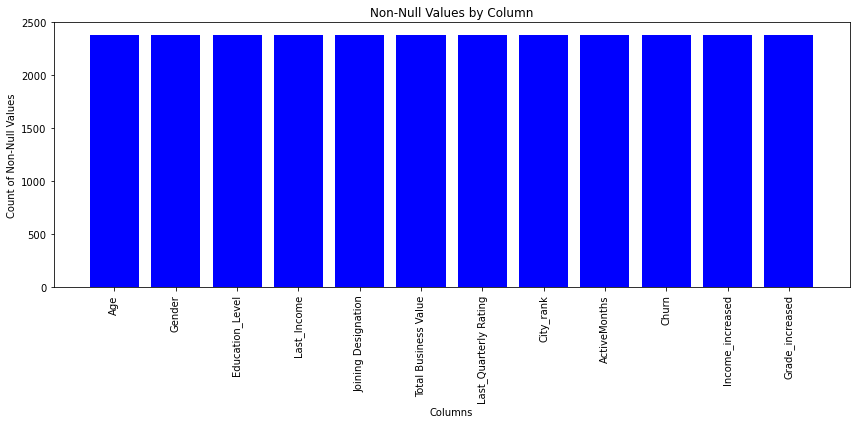

In [15]:
non_null_counts = df.notnull().sum()

# Create a bar graph for non-null values
plt.figure(figsize=(12, 6))
plt.bar(non_null_counts.index, non_null_counts.values, color='blue')

# Customize the plot
plt.xlabel('Columns')
plt.ylabel('Count of Non-Null Values')
plt.title('Non-Null Values by Column')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

##### Checking duplicate rows in dataset

In [16]:
df.duplicated().sum()

0

#### Insights 
Data has zero missing values in any columns 

In [17]:
df.describe()

,Age,Gender,Education_Level,Last_Income,Joining Designation,Total Business Value,Last_Quarterly Rating,City_rank,ActiveMonths,Churn,Income_increased,Grade_increased
count,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,33.663167,0.410332,1.00756,59334.157077,1.820244,4.586742e+06,1.427971,15.335573,16.729105,0.678706,0.018060,0.018060
std,5.983375,0.491997,0.81629,28383.666384,0.841433,9.127115e+06,0.809839,8.371843,19.664863,0.467071,0.133195,0.133195
min,21.000000,0.000000,0.00000,10747.000000,1.000000,-1.385530e+06,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.00000,39104.000000,1.000000,0.000000e+00,1.000000,8.000000,5.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,1.00000,55315.000000,2.000000,8.176800e+05,1.000000,15.000000,10.000000,1.000000,0.000000,0.000000
75%,37.000000,1.000000,2.00000,75986.000000,2.000000,4.173650e+06,2.000000,22.000000,19.000000,1.000000,0.000000,0.000000
max,58.000000,1.000000,2.00000,188418.000000,5.000000,9.533106e+07,4.000000,29.000000,103.000000,1.000000,1.000000,1.000000


##### Univariate analysis on numerical columns

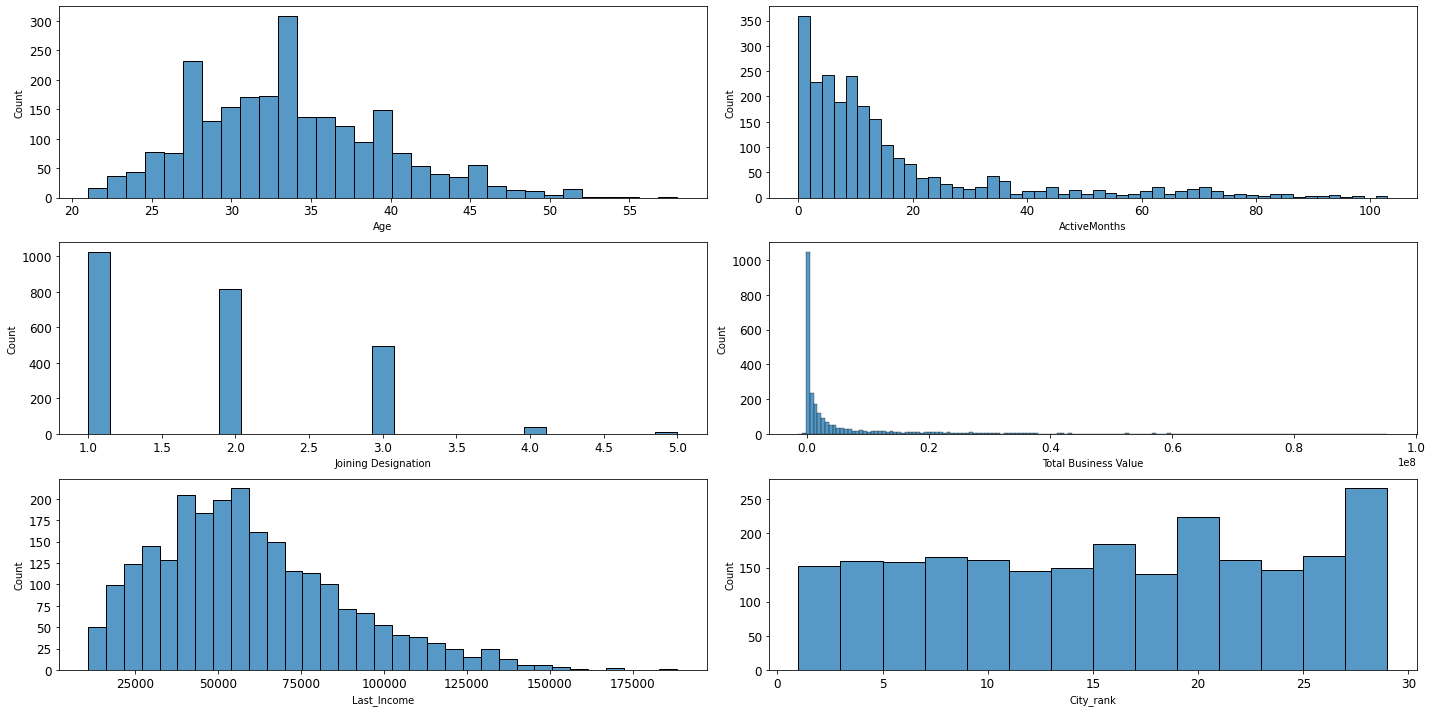

In [18]:
plt.figure(figsize=(20, 10))

plt.subplot(321)
sns.histplot(df['Age'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(322)
sns.histplot(df['ActiveMonths'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(323)
sns.histplot(df['Joining Designation'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(324)
sns.histplot(df['Total Business Value'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(325)
sns.histplot(df['Last_Income'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(326)
sns.histplot(df['City_rank'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

##### Checking for outliers

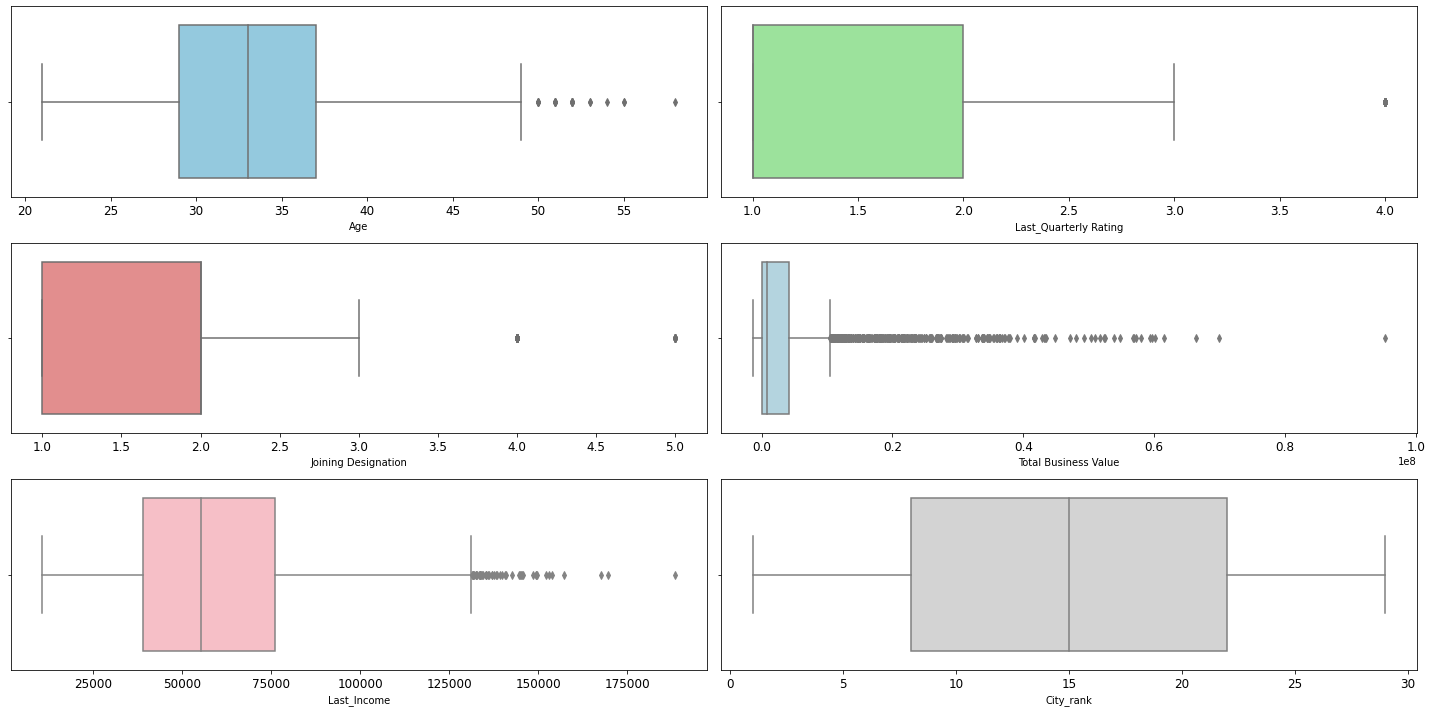

In [19]:
plt.figure(figsize=(20, 10))

plt.subplot(321)
sns.boxplot(data=df, x='Age', color='skyblue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(322)
sns.boxplot(data=df, x='Last_Quarterly Rating', color='lightgreen')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(323)
sns.boxplot(data=df, x='Joining Designation', color='lightcoral')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(324)
sns.boxplot(data=df, x='Total Business Value', color='lightblue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(325)
sns.boxplot(data=df, x='Last_Income', color='lightpink')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(326)
sns.boxplot(data=df, x='City_rank', color='lightgray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

#### Insights 
above boxplots shows taht these columns have outliers but we will not be treating them

### Bivariate analysis 

#### Joining designation V/s Churn 

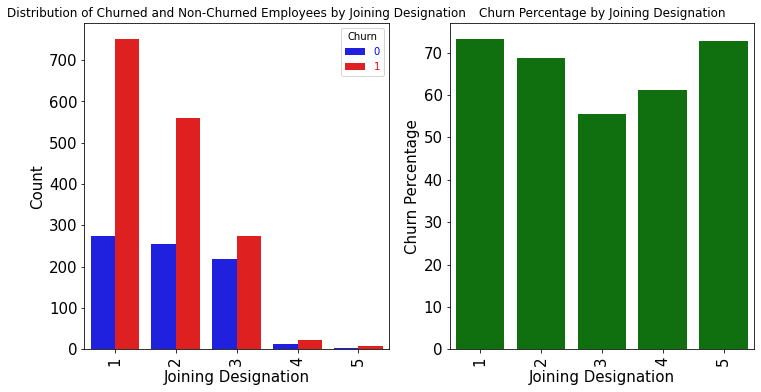

In [20]:
counts_df = df.groupby(['Joining Designation', 'Churn']).size().reset_index(name='Counts')
el = pd.crosstab(df['Joining Designation'],df['Churn']).reset_index()
el['Churn_Percentage'] = el[1]*100/(el[0]+el[1])

# Create a stacked bar chart for the distribution of churned and non-churned employees by Joining Designation
plt.figure(figsize=(12, 6))  # Adjust the figsize for a larger second graph
plt.subplot(121)
sns.barplot(x='Joining Designation', y='Counts', hue='Churn', data=counts_df, palette=['blue', 'red'])

# Customize the plot
plt.xlabel('Joining Designation', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of Churned and Non-Churned Employees by Joining Designation', fontsize=12)

# Specify the colors for the legend labels
legend_labels = {'Not Churned': 'blue', 'Churned': 'red'}

# Access the legend handles and labels
legend = plt.gca().get_legend()
for text, color in zip(legend.texts, [legend_labels['Not Churned'], legend_labels['Churned']]):
    text.set_color(color)
legend.set_title('Churn')

# Increase x and y-axis tick label sizes
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Create a bar chart for drop percentage
plt.subplot(122)  # Corrected subplot index
sns.barplot(x='Joining Designation', y='Churn_Percentage', data=el, color='green')  # Removed the figsize

# Customize the plot
plt.xlabel('Joining Designation', fontsize=15)
plt.ylabel('Churn Percentage', fontsize=15)
plt.title('Churn Percentage by Joining Designation', fontsize=12)

# Increase x and y-axis tick label sizes
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Adjust the layout with increased vertical spacing
plt.subplots_adjust(hspace=0.5)  # Adjust the hspace parameter

# Show the plots
plt.show()

In [76]:
#### City_rank V/s Churn 

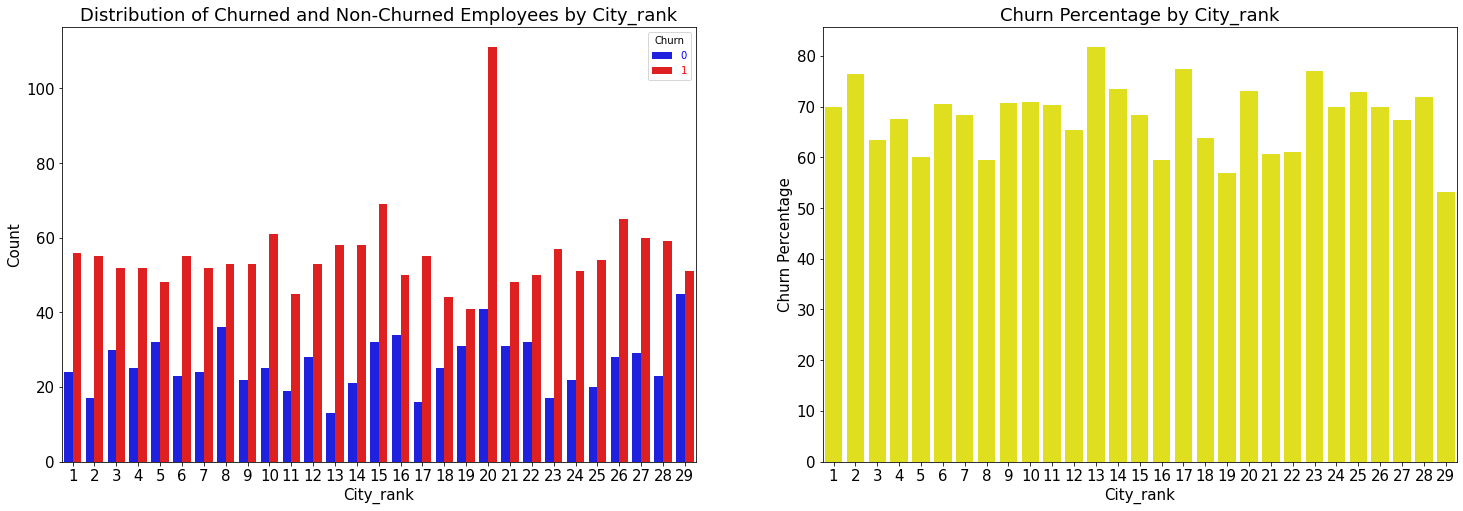

In [21]:
city_df = df.groupby(['City_rank', 'Churn']).size().reset_index(name='Counts')
cl = pd.crosstab(df['City_rank'],df['Churn']).reset_index()
cl['Churn_Percentage'] = cl[1]*100/(cl[0]+cl[1])

# Create a stacked bar chart for the distribution of churned and non-churned employees by Joining Designation
plt.figure(figsize=(25, 8))  # Adjust the figsize for a larger second graph
plt.subplot(121)
sns.barplot(x='City_rank', y='Counts', hue='Churn', data=city_df, palette=['blue', 'red'])

# Customize the plot
plt.xlabel('City_rank', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of Churned and Non-Churned Employees by City_rank', fontsize=18)

# Specify the colors for the legend labels
legend_labels = {'Not Churned': 'blue', 'Churned': 'red'}

# Access the legend handles and labels
legend = plt.gca().get_legend()
for text, color in zip(legend.texts, [legend_labels['Not Churned'], legend_labels['Churned']]):
    text.set_color(color)
legend.set_title('Churn')

# Increase x and y-axis tick label sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Create a bar chart for drop percentage
plt.subplot(122)  # Corrected subplot index
sns.barplot(x='City_rank', y='Churn_Percentage', data=cl, color='yellow')  # Removed the figsize

# Customize the plot
plt.xlabel('City_rank', fontsize=15)
plt.ylabel('Churn Percentage', fontsize=15)
plt.title('Churn Percentage by City_rank', fontsize=18)

# Increase x and y-axis tick label sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Adjust the layout with increased vertical spacing
plt.subplots_adjust(hspace=0.5)  # Adjust the hspace parameter

# Show the plots
plt.show()

#### Insight
Churn percentage for all cities are between 60% to 75%

#### Age V/s Churn 

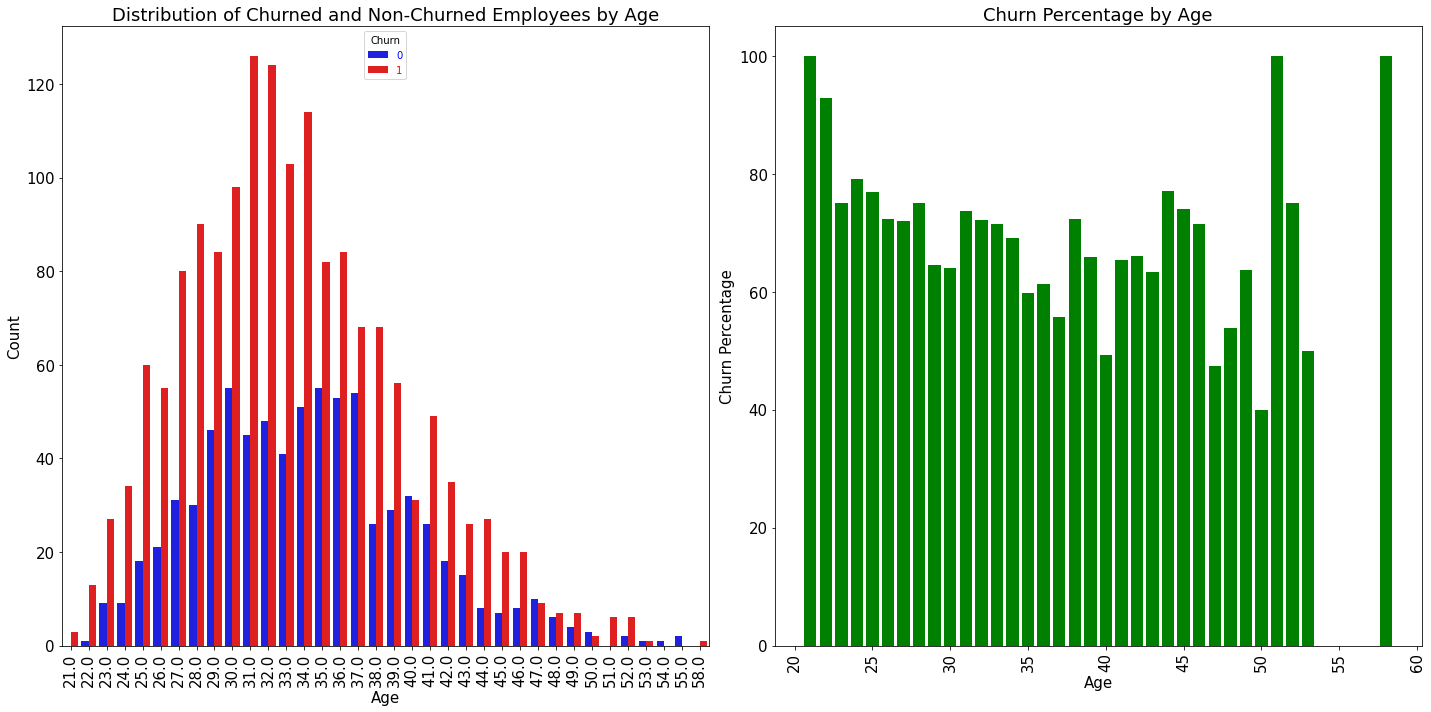

In [22]:
age_counts = df.groupby(['Age', 'Churn']).size().reset_index(name='Counts')
x = pd.crosstab(df['Age'],df['Churn']).reset_index()
x['Churn_Percentage'] = x[1]*100/(x[0]+x[1])

# Create a stacked bar chart for the distribution of churned and non-churned employees by age
plt.figure(figsize=(20, 10))
plt.subplot(121)
sns.barplot(x='Age', y='Counts', hue='Churn', data=age_counts, palette=['blue', 'red'])

# Customize the plot
plt.xlabel('Age', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of Churned and Non-Churned Employees by Age', fontsize=18)

# Specify the colors for the legend labels
legend_labels = {'Not Churned': 'blue', 'Churned': 'red'}

# Access the legend handles and labels
legend = plt.gca().get_legend()
for text, color in zip(legend.texts, [legend_labels['Not Churned'], legend_labels['Churned']]):
    text.set_color(color)
legend.set_title('Churn')

# Increase x and y-axis tick label sizes
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Create a bar chart for drop percentage
plt.subplot(122)
plt.bar(x["Age"], x["Churn_Percentage"], color='green')

# Customize the plot
plt.xlabel('Age', fontsize=15)
plt.ylabel('Churn Percentage', fontsize=15)
plt.title('Churn Percentage by Age', fontsize=18)

# Increase x and y-axis tick label sizes
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

#### Insight

Churn_percentage is very high for driver who are between 20 to 28 and 50 above 

#### Active months V/s Churn 

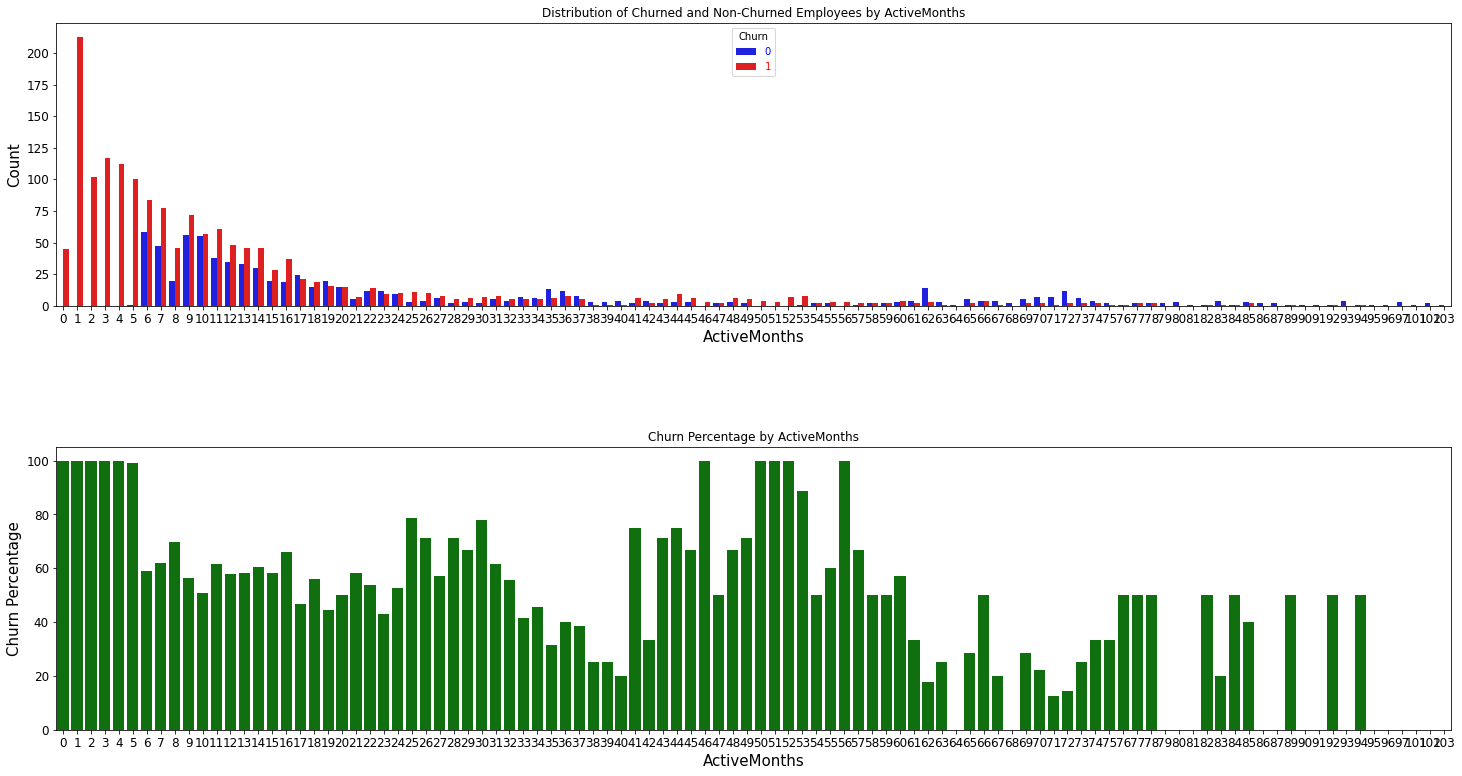

In [74]:
active_df = df.groupby(['ActiveMonths', 'Churn']).size().reset_index(name='Counts')
al = pd.crosstab(df['ActiveMonths'],df['Churn']).reset_index()
al['Churn_Percentage'] = al[1]*100/(al[0]+al[1])

# Create a stacked bar chart for the distribution of churned and non-churned employees by Joining Designation
plt.figure(figsize=(25, 13))  # Adjust the figsize for a larger second graph
plt.subplot(211)
sns.barplot(x='ActiveMonths', y='Counts', hue='Churn', data=active_df, palette=['blue', 'red'])

# Customize the plot
plt.xlabel('ActiveMonths', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of Churned and Non-Churned Employees by ActiveMonths', fontsize=12)

# Specify the colors for the legend labels
legend_labels = {'Not Churned': 'blue', 'Churned': 'red'}

# Access the legend handles and labels
legend = plt.gca().get_legend()
for text, color in zip(legend.texts, [legend_labels['Not Churned'], legend_labels['Churned']]):
    text.set_color(color)
legend.set_title('Churn')

# Increase x and y-axis tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Create a bar chart for drop percentage
plt.subplot(212)  # Corrected subplot index
sns.barplot(x='ActiveMonths', y='Churn_Percentage', data=al, color='green')  # Removed the figsize

# Customize the plot
plt.xlabel('ActiveMonths', fontsize=15)
plt.ylabel('Churn Percentage', fontsize=15)
plt.title('Churn Percentage by ActiveMonths', fontsize=12)

# Increase x and y-axis tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the layout with increased vertical spacing
plt.subplots_adjust(hspace=0.5)  # Adjust the hspace parameter

# Show the plots
plt.show()

#### Insight 
from above charts we can see that for few driver who were active formonths 1 to 5 and then between 45 and 56 have 100% churned and after 65 active months churn rate is constant to 50%

##### Performing Chi-square test for testing assosiation between categorical columns and plotting heatmap for these features
'Gender', 'Income_increased', 'Grade_increased','Education_Level', 'Last_Quarterly Rating', 'Joining Designation' 


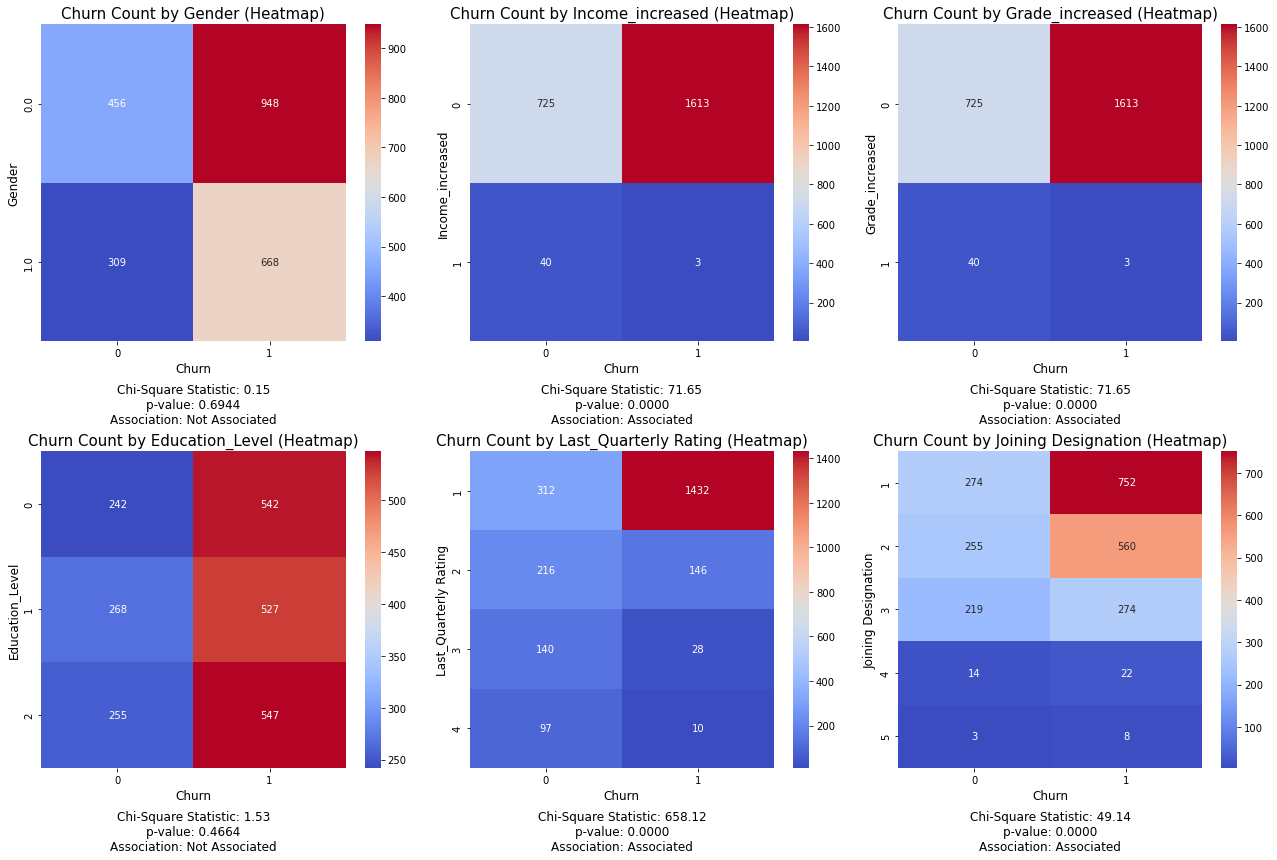

In [23]:
from scipy.stats import chi2_contingency

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Initialize a dictionary to store chi-square test results and associations
chi2_results = {}

# Columns to analyze
columns_to_analyze = [
    'Gender', 'Income_increased', 'Grade_increased',
    'Education_Level', 'Last_Quarterly Rating', 'Joining Designation'
]

for i, column in enumerate(columns_to_analyze):
    # Create a crosstab
    cross_tab = pd.crosstab(df[column], df['Churn'])
    
    # Create a heatmap
    sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d', ax=axes[i // 3, i % 3])
    
    # Customize the plot
    axes[i // 3, i % 3].set_xlabel('Churn', fontsize=12)
    axes[i // 3, i % 3].set_ylabel(column, fontsize=12)
    axes[i // 3, i % 3].set_title(f'Churn Count by {column} (Heatmap)', fontsize=15)
    
    # Run the chi-square test
    chi2, p, _, _ = chi2_contingency(cross_tab)
    chi2_results[column] = {'Chi-Square Statistic': chi2, 'p-value': p}
    
    # Determine if the variables are associated or not based on p-value significance level (e.g., 0.05)
    if p < 0.05:
        association = 'Associated'
    else:
        association = 'Not Associated'
    
    # Print the chi-square test result below the heatmap
    axes[i // 3, i % 3].text(
        0.5, -0.2, f"Chi-Square Statistic: {chi2:.2f}\np-value: {p:.4f}\nAssociation: {association}",
        horizontalalignment='center', verticalalignment='center',
        transform=axes[i // 3, i % 3].transAxes, fontsize=12
    )

plt.tight_layout()
plt.show()

#### Insights 
Churn rate is independant of Gender and Education level while it has assosiation with 'Income_increased', 'Grade_increased',
'Last_Quarterly Rating', 'Joining Designation'

#### Performing Chi-square test for testing assosiation between categorical columns and plotting heatmap after creating these new features for better undersatnding of corresponding numerical columns (Income category and Total business value category)

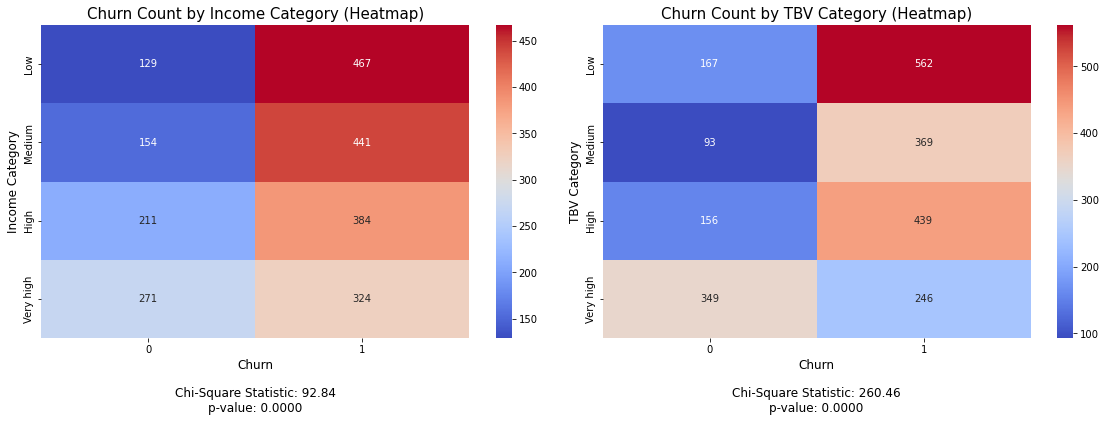

Chi-Square Test Results:
Chi-Square Statistic for 'Income_Category': 92.84, p-value: 0.0000
Chi-Square Statistic for 'TBV_Category': 260.46, p-value: 0.0000


In [24]:
# Define the percentiles for binning (quartiles)
percentiles = [0, 0.25, 0.50, 0.75, 1]

# Bin the 'Last_Income' column according to percentiles
df['Income_Category'] = pd.qcut(df['Last_Income'], q=percentiles, labels=['Low', 'Medium', 'High', 'Very high'])

# Bin the 'Total Business Value' column according to percentiles
df['TBV_Category'] = pd.qcut(df['Total Business Value'], q=percentiles, labels=['Low', 'Medium', 'High', 'Very high'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot heatmap and chi-square test result for 'Income_Category'
cross_tab_income = pd.crosstab(df['Income_Category'], df['Churn'])
sns.heatmap(cross_tab_income, annot=True, cmap='coolwarm', fmt='d', ax=axes[0])
axes[0].set_xlabel('Churn', fontsize=12)
axes[0].set_ylabel('Income Category', fontsize=12)
axes[0].set_title('Churn Count by Income Category (Heatmap)', fontsize=15)
chi2_income, p_income, _, _ = chi2_contingency(cross_tab_income)
axes[0].text(0.5, -0.2, f"Chi-Square Statistic: {chi2_income:.2f}\np-value: {p_income:.4f}",
             horizontalalignment='center', verticalalignment='center',
             transform=axes[0].transAxes, fontsize=12)

# Plot heatmap and chi-square test result for 'TBV_Category'
cross_tab_tbv = pd.crosstab(df['TBV_Category'], df['Churn'])
sns.heatmap(cross_tab_tbv, annot=True, cmap='coolwarm', fmt='d', ax=axes[1])
axes[1].set_xlabel('Churn', fontsize=12)
axes[1].set_ylabel('TBV Category', fontsize=12)
axes[1].set_title('Churn Count by TBV Category (Heatmap)', fontsize=15)
chi2_tbv, p_tbv, _, _ = chi2_contingency(cross_tab_tbv)
axes[1].text(0.5, -0.2, f"Chi-Square Statistic: {chi2_tbv:.2f}\np-value: {p_tbv:.4f}",
             horizontalalignment='center', verticalalignment='center',
             transform=axes[1].transAxes, fontsize=12)

plt.tight_layout()
plt.show()

# Print chi-square test results
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic for 'Income_Category': {chi2_income:.2f}, p-value: {p_income:.4f}")
print(f"Chi-Square Statistic for 'TBV_Category': {chi2_tbv:.2f}, p-value: {p_tbv:.4f}")

#### Insights
Income Category and Total Business value both has assosiation with churn

In [25]:
df['Churn'].value_counts()*100/len(df)

1    67.870643
0    32.129357
Name: Churn, dtype: float64

#### Insights 
this is not an imbalance data

##### PLotting Heatmap for undersatnding correlation between features

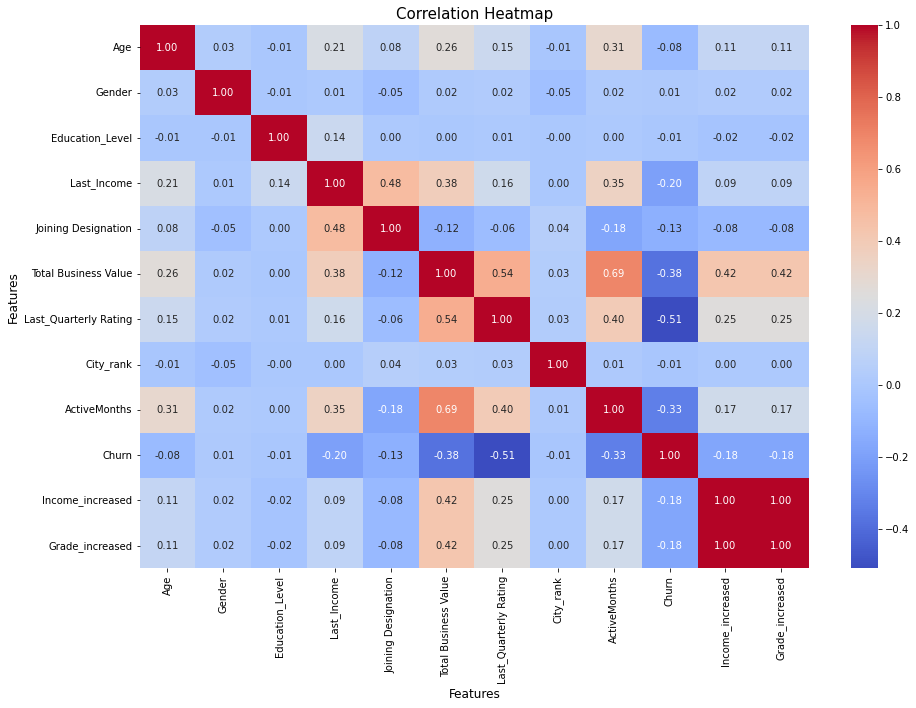

In [26]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Customize plot labels and title
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Correlation Heatmap', fontsize=15)

plt.show()

##### Dropping those new feature which we created for understanding their corresponding numerical features 

In [27]:
df.drop(columns = ['Income_Category','TBV_Category'], axis = 1, inplace = True)

##### Extracting Dependent and Independent feature for model building

In [28]:
X = df.drop('Churn',axis = 1)
y = df['Churn']

In [29]:
print(X.shape)
print(y.shape)

(2381, 11)
(2381,)


#### Performing Train test split on our X and y

In [30]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=42, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X,y ,random_state=42, test_size=0.20)

In [31]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1904, 11)
(477, 11)
(477, 11)
(1904,)
(477,)
(477,)


##### Scalling our numerica features 

In [32]:
from sklearn.preprocessing import StandardScaler
# Select the features to scale
features_to_scale = ['Age', 'Education_Level', 'Last_Income', 'Joining Designation',
                     'Total Business Value', 'Last_Quarterly Rating', 'City_rank', 'ActiveMonths']

# Create a StandardScaler
scaler = StandardScaler()

# Scale the selected features
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Display the scaled DataFrame
X_train.head()

,Age,Gender,Education_Level,Last_Income,Joining Designation,Total Business Value,Last_Quarterly Rating,City_rank,ActiveMonths,Income_increased,Grade_increased
457,-0.964094,0.0,-1.241468,0.996174,1.386445,-0.507968,-0.534030,-0.643582,-0.496068,0,0
1739,0.034710,0.0,-1.241468,-0.735645,0.202151,-0.457571,-0.534030,0.547148,-0.647740,0,0
1848,-1.130562,0.0,-1.241468,-0.226293,-0.982143,-0.507968,-0.534030,-0.762656,-0.041051,0,0
1410,-0.631160,1.0,1.214381,-0.889829,-0.982143,-0.130762,0.665019,0.785294,0.110621,0,0
829,2.198786,0.0,-1.241468,1.088016,-0.982143,1.912452,1.864069,0.785294,2.790164,0,0


#### Building BaggingClassifier ML model

In [33]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

##### Checking accuracy of our model on train and test set

In [34]:
from sklearn.metrics import accuracy_score

# Calculate accuracy on the training dataset
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the testing dataset
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.99
Testing Accuracy: 0.81


#### Insights 
Model is overfitting 

#### Action 
we will do hyper parameter tuning for better results 

##### Doing Hyperparameter tuning using X_val and y_val dataset by doining cross validation

In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

# Define the BaggingClassifier
base_estimator = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_estimator=base_estimator)

# Define the hyperparameter distribution
param_dist = {
    'n_estimators': randint(10, 200),           # Number of base estimators
    'max_samples': [0.5, 0.7, 0.8, 1.0],       # Fraction of samples used for training each base estimator
    'max_features': [0.5, 0.7, 0.8, 1.0],      # Fraction of features used for training each base estimator
    'base_estimator__max_depth': [2,3,5,6,7,9,10,12,13,15],  # Max depth of the base DecisionTreeClassifier
    'base_estimator__min_samples_split': randint(2, 11),  # Min samples required to split an internal node
    # Add more hyperparameters as needed
}

# Create the RandomizedSearchCV object with cross-validation
random_search = RandomizedSearchCV(estimator=bagging_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# Fit the model to the data
random_search.fit(X_val, y_val)

# Print the best hyperparameters and corresponding accuracy
best_params = random_search.best_params_
best_accuracy = random_search.best_score_

print("Best Hyperparameters:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_accuracy:.2f}")

Best Hyperparameters:
{'base_estimator__max_depth': 5, 'base_estimator__min_samples_split': 10, 'max_features': 0.7, 'max_samples': 0.8, 'n_estimators': 199}
Best Cross-Validation Accuracy: 0.82


##### rebuilding our BaggingClassifier with best parameter which we got after cross validation

In [36]:
# Define the base estimator with the specified hyperparameters
base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_split=6)

# Create the BaggingClassifier with the specified hyperparameters
model = BaggingClassifier(
    base_estimator=base_estimator,
    n_estimators=169,
    max_samples=0.7,
    max_features=1.0,
    bootstrap=True,
    random_state=42  # You can set a random state for reproducibility
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#### Rechecking accuracy of our model

In [37]:
# Calculate accuracy on the training dataset
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the testing dataset
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.81
Testing Accuracy: 0.82


#### Insight 
although Training accuracy has gone down but test and train both accuracies are very close to each other now hence we have reduced overfitting

##### Plotting confusion_matrix for train and test data

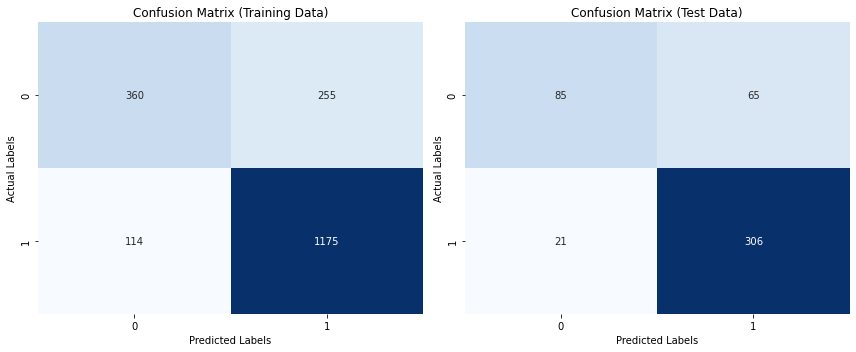

In [38]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for the training data
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)

# Calculate the confusion matrix for the test data
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix for the training data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix (Training Data)')

# Plot the confusion matrix for the test data
plt.subplot(1, 2, 2)
sns.heatmap(test_confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix (Test Data)')

plt.tight_layout()
plt.show()

#### Checking values for other classification metrics like recall , precision etc

In [39]:
from sklearn.metrics import classification_report

# Calculate classification metrics for the training data
train_classification_report = classification_report(y_train, y_train_pred)

# Calculate classification metrics for the test data
test_classification_report = classification_report(y_test, y_test_pred)

# Print classification metrics for the training data
print("Classification Report for Training Data:\n", train_classification_report)

# Print classification metrics for the test data
print("\nClassification Report for Test Data:\n", test_classification_report)

Classification Report for Training Data:
               precision    recall  f1-score   support

           0       0.76      0.59      0.66       615
           1       0.82      0.91      0.86      1289

    accuracy                           0.81      1904
   macro avg       0.79      0.75      0.76      1904
weighted avg       0.80      0.81      0.80      1904


Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.80      0.57      0.66       150
           1       0.82      0.94      0.88       327

    accuracy                           0.82       477
   macro avg       0.81      0.75      0.77       477
weighted avg       0.82      0.82      0.81       477



#### Insight 
we are having precission on lower side but in our senario Precision is an important metrics 
 

##### building ROC curve

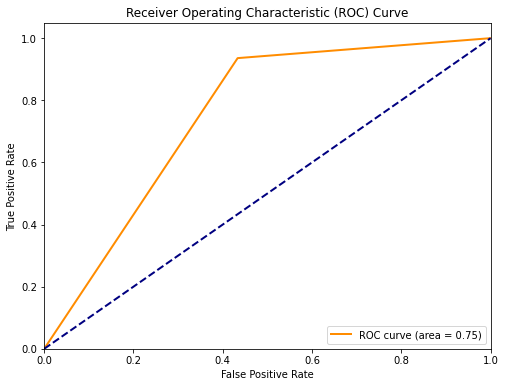

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve for the test data
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Calculate the AUC (Area Under the Curve) score
roc_auc = roc_auc_score(y_train, y_train_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##### crating a Boosting ML model

In [41]:
from sklearn.ensemble import AdaBoostClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)

# Create the AdaBoost classifier
adaboost_model = AdaBoostClassifier(base_classifier, n_estimators=50, learning_rate=1.0, random_state=42)

# Fit the AdaBoost model to your training data
adaboost_model.fit(X_train, y_train)

# Make predictions on the training and test data
y_train_pred = adaboost_model.predict(X_train)
y_test_pred = adaboost_model.predict(X_test)

##### Checking accuracy of models for train and test data

In [42]:
# Calculate accuracy on the training dataset
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the testing dataset
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.86
Testing Accuracy: 0.83


##### plotting confusion_matrix for train and test set

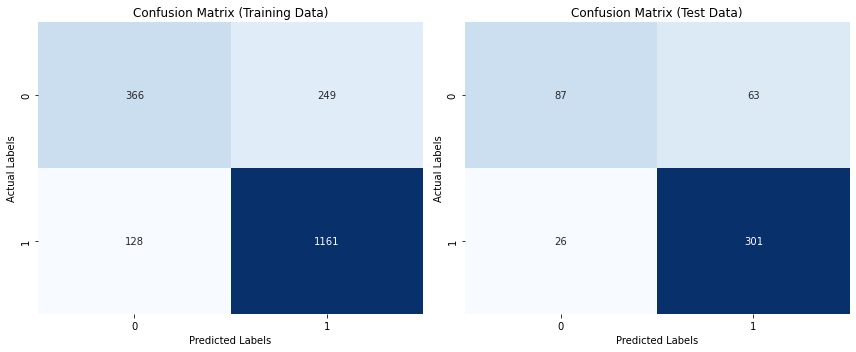

In [77]:
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)

# Calculate the confusion matrix for the test data
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix for the training data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix (Training Data)')

# Plot the confusion matrix for the test data
plt.subplot(1, 2, 2)
sns.heatmap(test_confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix (Test Data)')

plt.tight_layout()
plt.show()

##### Checking for other metrics like precision , recall etc

In [78]:
from sklearn.metrics import classification_report

# Calculate classification metrics for the training data
train_classification_report = classification_report(y_train, y_train_pred)

# Calculate classification metrics for the test data
test_classification_report = classification_report(y_test, y_test_pred)

# Print classification metrics for the training data
print("Classification Report for Training Data:\n", train_classification_report)

# Print classification metrics for the test data
print("\nClassification Report for Test Data:\n", test_classification_report)

Classification Report for Training Data:
               precision    recall  f1-score   support

           0       0.74      0.60      0.66       615
           1       0.82      0.90      0.86      1289

    accuracy                           0.80      1904
   macro avg       0.78      0.75      0.76      1904
weighted avg       0.80      0.80      0.80      1904


Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.77      0.58      0.66       150
           1       0.83      0.92      0.87       327

    accuracy                           0.81       477
   macro avg       0.80      0.75      0.77       477
weighted avg       0.81      0.81      0.81       477



#### Comparing both Bagging and Boosting ML model

In [79]:
# # Bagging Classifier model
# Classification Report for Training Data:
#                precision    recall  f1-score   support

#            0       0.76      0.59      0.66       615
#            1       0.82      0.91      0.86      1289

#     accuracy                           0.81      1904
#    macro avg       0.79      0.75      0.76      1904
# weighted avg       0.80      0.81      0.80      1904


# Classification Report for Test Data:
#                precision    recall  f1-score   support

#            0       0.80      0.57      0.66       150
#            1       0.82      0.94      0.88       327

#     accuracy                           0.82       477
#    macro avg       0.81      0.75      0.77       477
# weighted avg       0.82      0.82      0.81       477


# # Boosting Classifier model
# Classification Report for Training Data:
#                precision    recall  f1-score   support

#            0       0.74      0.60      0.66       615
#            1       0.82      0.90      0.86      1289

#     accuracy                           0.80      1904
#    macro avg       0.78      0.75      0.76      1904
# weighted avg       0.80      0.80      0.80      1904


# Classification Report for Test Data:
#                precision    recall  f1-score   support

#            0       0.77      0.58      0.66       150
#            1       0.83      0.92      0.87       327

#     accuracy                           0.81       477
#    macro avg       0.80      0.75      0.77       477
# weighted avg       0.81      0.81      0.81       477

#### Insight 
On comparing both models it seems like Bagging is giving us a better result it is slightly higher in all metrics from the Boosting model

#### Plotting ROC curve for Boosting model

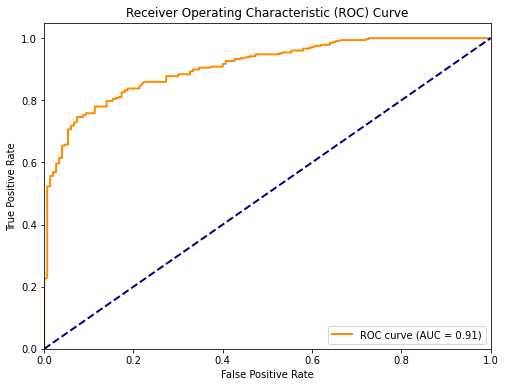

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have already trained your AdaBoostClassifier (best_adaboost_model)
# and have your predicted probabilities for the positive class (class 1) on the validation data.

# Get the predicted probabilities for the positive class (class 1)
y_val_probabilities = best_adaboost_model.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_probabilities)

# Calculate the AUC (Area Under the ROC Curve)
roc_auc = roc_auc_score(y_val, y_val_probabilities)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##### Plotting Important features as per bagging and boosting models 

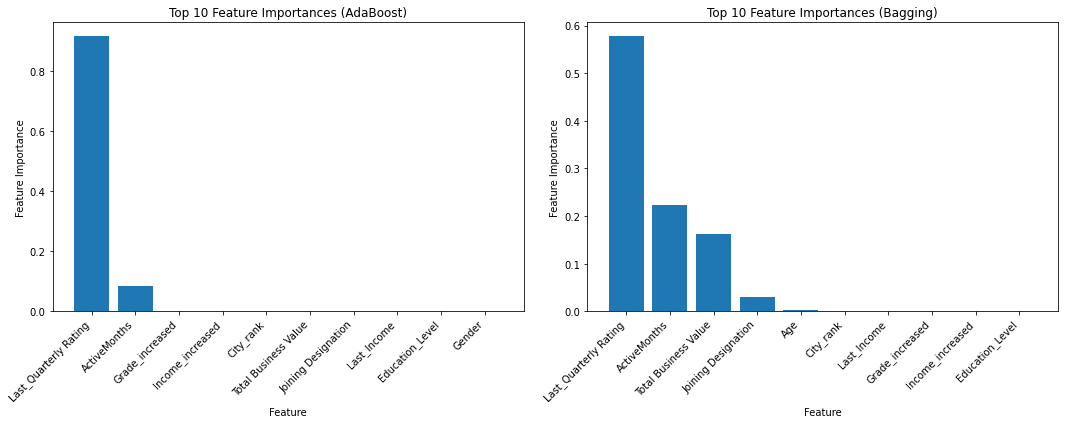

In [62]:
# Get feature importances for AdaBoost
feature_importances_adaboost = best_adaboost_model.feature_importances_

# Get feature importances for Bagging
feature_importances_bagging = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Get the names of the features (assuming you have them in a list or DataFrame)
feature_names = X_train.columns.tolist()  # Replace with your actual feature names

# Sort the feature importances in descending order for AdaBoost
sorted_idx_adaboost = np.argsort(feature_importances_adaboost)[::-1]

# Sort the feature importances in descending order for Bagging
sorted_idx_bagging = np.argsort(feature_importances_bagging)[::-1]

# Rearrange feature names based on feature importance ranking for AdaBoost
sorted_feature_names_adaboost = [feature_names[i] for i in sorted_idx_adaboost]

# Rearrange feature names based on feature importance ranking for Bagging
sorted_feature_names_bagging = [feature_names[i] for i in sorted_idx_bagging]

# Plot the top N feature importances side by side
top_n = 10  # Change this value to the number of top features you want to display
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot AdaBoost feature importances
axes[0].bar(range(top_n), feature_importances_adaboost[sorted_idx_adaboost][:top_n], align="center")
axes[0].set_xticks(range(top_n))
axes[0].set_xticklabels(sorted_feature_names_adaboost[:top_n], rotation=45, ha="right")
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Feature Importance")
axes[0].set_title(f"Top {top_n} Feature Importances (AdaBoost)")

# Plot Bagging feature importances
axes[1].bar(range(top_n), feature_importances_bagging[sorted_idx_bagging][:top_n], align="center")
axes[1].set_xticks(range(top_n))
axes[1].set_xticklabels(sorted_feature_names_bagging[:top_n], rotation=45, ha="right")
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Feature Importance")
axes[1].set_title(f"Top {top_n} Feature Importances (Bagging)")

plt.tight_layout()
plt.show()

#### Insights 
Last_Quarterly Rating, ActiveMonths, Grade_increased, Total_business Value these Features seems very important 

inference from the analysis done on above slides 
1. Drivers with Last_Quarterly Rating == 1 , are more likly to Churn 
2. Drivers at very early stage of joining or after 40 months are more likly to Churn
3. Drivers who are bringing low to medium Total_business Value are more likly to Churn
4. Driver who have joining designation == 1 are more likly to Churn

#### Reccomendation 
1. Ola can be more in touch with their driver when they are in their initial stages , Ola should try to give them more business 
2. Ola should look after those driver, who have spend significant time with ola but bringing medium business , Ola can increse their grade or give them training on soft skills so that their grade can be better and they can bring more business 
3. Ola can be more cautious while hiring driver with low joining designation as they are more likly to Churn
4. Ola can improve grade and income of few deserving drivers as it is one of the major cause behind Churn